In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import vector
import os
vector.register_awkward()
import mplhep
plt.style.use(mplhep.style.CMS)

file = uproot.open("/eos/user/d/ddharmen/updated_cmssw/CMSSW_14_0_0_pre3/src/FastPUPPI/NtupleProducer/python/perfNano_TTbar_PU200.root")
print(file.keys())
data = file["Events"]

def getBranch(data, l1jet):
    
    # Get list of branches relating to the given jet
    print("Getting list of interesting branches")
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    print("Querying the array with interesting branches")
    l1jetData = data.arrays(interestingBranches)
    
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    print("Splitting branch names on _ to get renamed fields")
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    print("Returning an ak array of the relevant data with the renamed fields")
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    
    return quarks4mom

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [3]:
hsc8Jets_DC = getBranch(data=data, l1jet="HSC9x9SC8DCJets_")
hsc8Jets = getBranch(data=data, l1jet="HSC9x9SC8Jets_")
sc8Jets = getBranch(data=data, l1jet="HSC9x9SC8SCJets_")
genJets= getBranch(data=data, l1jet="GenJets_")

Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields


In [45]:

# Assuming sc8Jets_DC contains reconstructed jets and genJets contains the generated jets information

# Step 1: Extract eta and phi for all jets from both genJets and sc8Jets_DC
gen_jet_eta = genJets.eta  # Extracting eta from generated jets
reco_jet_eta_sc = sc8Jets.eta  # Extracting eta from reconstructed jets
reco_jet_eta_hsc = hsc8Jets.eta
reco_jet_eta_hsc_dc = hsc8Jets_DC.eta


gen_jet_phi = genJets.phi  # Extracting phi from generated jets
reco_jet_phi_sc = sc8Jets.phi  # Extracting phi from reconstructed jets
reco_jet_phi_hsc = hsc8Jets.phi
reco_jet_phi_hsc_dc = hsc8Jets_DC.phi

mask_sc = (ak.num(gen_jet_eta) == ak.num(reco_jet_eta_sc))
mask_hsc = (ak.num(gen_jet_eta) == ak.num(reco_jet_eta_hsc))
mask_hsc_dc = (ak.num(gen_jet_eta) == ak.num(reco_jet_eta_hsc_dc))


# Apply the mask to both generated and reconstructed jets to ensure matching structure
gen_jet_eta_masked_sc = gen_jet_eta[mask_sc]
gen_jet_eta_masked_hsc = gen_jet_eta[mask_hsc]
gen_jet_eta_masked_hsc_dc = gen_jet_eta[mask_hsc_dc]

gen_jet_phi_masked_sc = gen_jet_phi[mask_sc]
gen_jet_phi_masked_hsc = gen_jet_phi[mask_hsc]
gen_jet_phi_masked_hsc_dc = gen_jet_phi[mask_hsc_dc]



reco_jet_eta_masked_sc = reco_jet_eta_sc[mask_sc]
reco_jet_eta_masked_hsc = reco_jet_eta_hsc[mask_hsc]
reco_jet_eta_masked_hsc_dc = reco_jet_eta_hsc_dc[mask_hsc_dc]



reco_jet_phi_masked_sc = reco_jet_phi_sc[mask_sc]
reco_jet_phi_masked_hsc = reco_jet_phi_hsc[mask_hsc]
reco_jet_phi_masked_hsc_dc = reco_jet_phi_hsc_dc[mask_hsc_dc]


# Step 3: Calculate the residuals (differences) for all jets between masked genJets and sc8Jets_DC
delta_eta_all_sc = reco_jet_eta_masked_sc - gen_jet_eta_masked_sc
delta_phi_all_sc = reco_jet_phi_masked_sc - gen_jet_phi_masked_sc

delta_eta_all_hsc = reco_jet_eta_masked_hsc - gen_jet_eta_masked_hsc
delta_phi_all_hsc = reco_jet_phi_masked_hsc - gen_jet_phi_masked_hsc

delta_eta_all_hsc_dc = reco_jet_eta_masked_hsc_dc - gen_jet_eta_masked_hsc_dc
delta_phi_all_hsc_dc = reco_jet_phi_masked_hsc_dc - gen_jet_phi_masked_hsc_dc


# # Step 3: Flatten the arrays to handle all jets together across all events
delta_eta_all_np_sc = ak.to_numpy(ak.flatten(delta_eta_all_sc))
delta_phi_all_np_sc = ak.to_numpy(ak.flatten(delta_phi_all_sc))

delta_eta_all_np_hsc = ak.to_numpy(ak.flatten(delta_eta_all_hsc))
delta_phi_all_np_hsc = ak.to_numpy(ak.flatten(delta_phi_all_hsc))

delta_eta_all_np_hsc_dc = ak.to_numpy(ak.flatten(delta_eta_all_hsc_dc))
delta_phi_all_np_hsc_dc = ak.to_numpy(ak.flatten(delta_phi_all_hsc_dc))

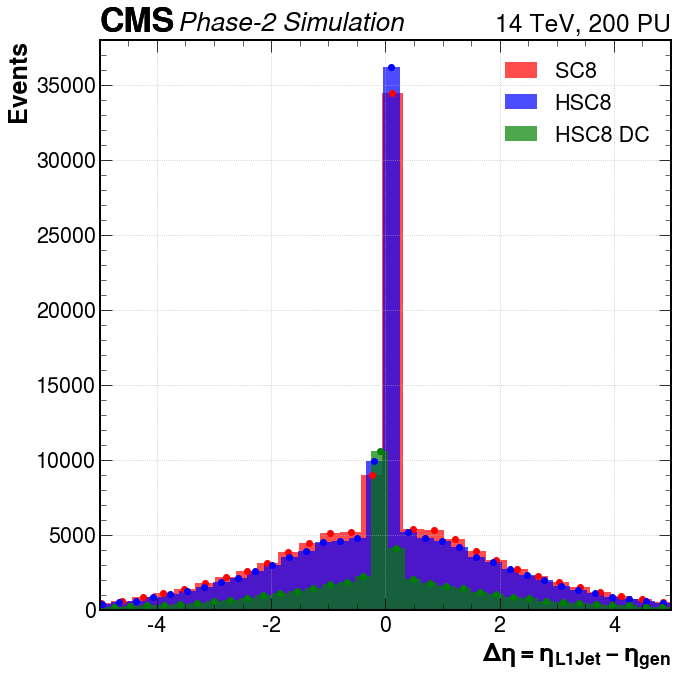

In [67]:
# ------------------------------------------------Eta resolution (not normalised)-----------------------------------------

nbins=50
plt.style.use(mplhep.style.ROOT)

hist_values_sc, bin_edges_sc = np.histogram(delta_eta_all_np_sc, bins=nbins)
hist_values_hsc, bin_edges_hsc = np.histogram(delta_eta_all_np_hsc, bins=nbins)
hist_values_hsc_dc, bin_edges_hsc_dc = np.histogram(delta_eta_all_np_hsc_dc, bins=nbins)

bin_centers_sc = (bin_edges_sc[:-1] + bin_edges_sc[1:]) / 2
bin_centers_hsc = (bin_edges_hsc[:-1] + bin_edges_hsc[1:]) / 2
bin_centers_hsc_dc = (bin_edges_hsc_dc[:-1] + bin_edges_hsc_dc[1:]) / 2



# Step 3: Plot the histogram
plt.hist(delta_eta_all_np_sc, bins=nbins, color='red', alpha=0.7, label='SC8')
plt.hist(delta_eta_all_np_hsc, bins=nbins, color='blue', alpha=0.7, label='HSC8')
plt.hist(delta_eta_all_np_hsc_dc, bins=nbins, color='green', alpha=0.7, label='HSC8 DC')


plt.plot(bin_centers_sc, hist_values_sc, marker='o', linestyle='', color='red')
plt.plot(bin_centers_hsc, hist_values_hsc, marker='o', linestyle='', color='b')
plt.plot(bin_centers_hsc_dc, hist_values_hsc_dc, marker='o', linestyle='', color='g')


# Step 5: Additional plot settings

plt.grid(True)
plt.legend()

plt.title('')
plt.xlabel(r'$\Delta \eta = \eta_{L1Jet} - \eta_{gen} $', fontsize=25, fontweight='bold')
plt.ylabel('Events', fontsize=25, fontweight='bold')
plt.grid(True)
plt.xlim(-5,5)  # Set x-axis range for eta resolution
plt.legend()

mplhep.cms.text("Phase-2 Simulation")
# mplhep.cms.text("")
# mplhep.cms.label("Phase-2 Simulation", com= 14, rlabel = "",llabel="")
mplhep.cms.label("",llabel="",rlabel="14 TeV, 200 PU")

# Show the plots
plt.tight_layout()
plt.show()

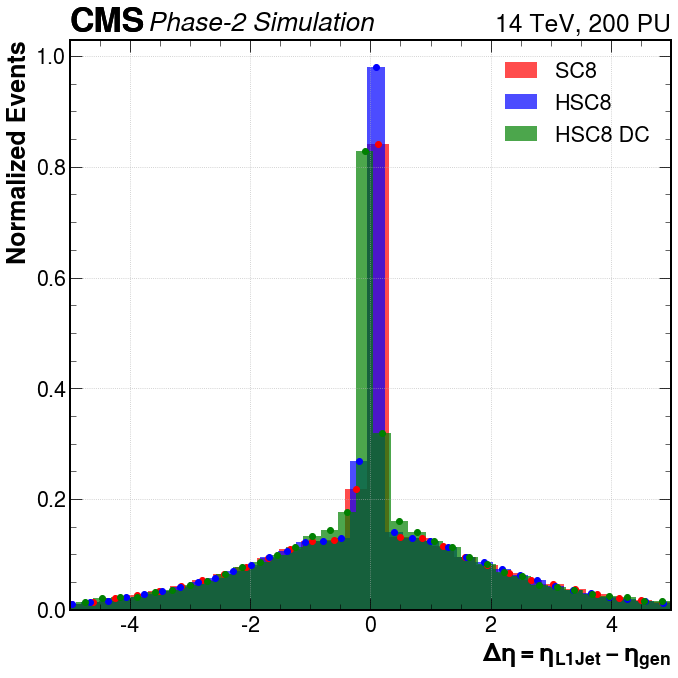

In [69]:
# ------------------------------------------------Eta resolution (not normalised)-----------------------------------------

hist_values_sc, bin_edges_sc = np.histogram(delta_eta_all_np_sc, bins=nbins, density=True)
hist_values_hsc, bin_edges_hsc = np.histogram(delta_eta_all_np_hsc, bins=nbins, density=True)
hist_values_hsc_dc, bin_edges_hsc_dc = np.histogram(delta_eta_all_np_hsc_dc, bins=nbins, density=True)

# Step 2: Calculate the bin centers for plotting the markers
bin_centers_sc = (bin_edges_sc[:-1] + bin_edges_sc[1:]) / 2
bin_centers_hsc = (bin_edges_hsc[:-1] + bin_edges_hsc[1:]) / 2
bin_centers_hsc_dc = (bin_edges_hsc_dc[:-1] + bin_edges_hsc_dc[1:]) / 2

# Step 3: Plot the normalized histograms
plt.hist(delta_eta_all_np_sc, bins=nbins, color='red', alpha=0.7, label='SC8', density=True)
plt.hist(delta_eta_all_np_hsc, bins=nbins, color='blue', alpha=0.7, label='HSC8', density=True)
plt.hist(delta_eta_all_np_hsc_dc, bins=nbins, color='green', alpha=0.7, label='HSC8 DC', density=True)

# Step 4: Plot the markers for the histograms
plt.plot(bin_centers_sc, hist_values_sc, marker='o', linestyle='', color='red')
plt.plot(bin_centers_hsc, hist_values_hsc, marker='o', linestyle='', color='blue')
plt.plot(bin_centers_hsc_dc, hist_values_hsc_dc, marker='o', linestyle='', color='green')

# Step 5: Additional plot settings
plt.grid(True)
plt.legend()

plt.xlabel(r'$\Delta \eta = \eta_{L1Jet} - \eta_{gen} $', fontsize=25, fontweight='bold')
plt.ylabel('Normalized Events', fontsize=25, fontweight='bold')
plt.xlim(-5, 5)  # Set x-axis range for eta resolution
plt.legend()

# Add CMS-style label
mplhep.cms.text("Phase-2 Simulation")
mplhep.cms.label("", llabel="", rlabel="14 TeV, 200 PU")

# Show the plots
plt.tight_layout()
plt.show()

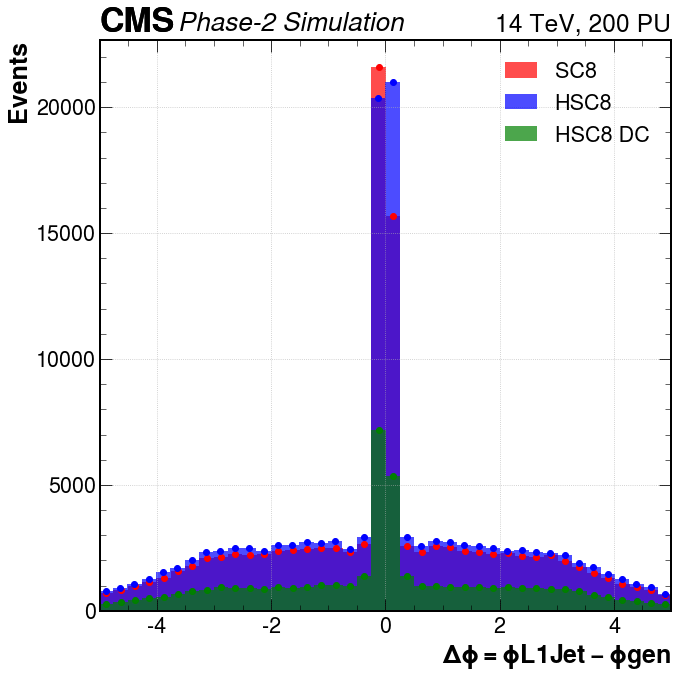

In [70]:
# ------------------------------------------------Phi resolution (not normalised)-----------------------------------------

nbins=50
plt.style.use(mplhep.style.ROOT)

hist_values_sc, bin_edges_sc = np.histogram(delta_phi_all_np_sc, bins=nbins)
hist_values_hsc, bin_edges_hsc = np.histogram(delta_phi_all_np_hsc, bins=nbins)
hist_values_hsc_dc, bin_edges_hsc_dc = np.histogram(delta_phi_all_np_hsc_dc, bins=nbins)

bin_centers_sc = (bin_edges_sc[:-1] + bin_edges_sc[1:]) / 2
bin_centers_hsc = (bin_edges_hsc[:-1] + bin_edges_hsc[1:]) / 2
bin_centers_hsc_dc = (bin_edges_hsc_dc[:-1] + bin_edges_hsc_dc[1:]) / 2



# Step 3: Plot the histogram
plt.hist(delta_phi_all_np_sc, bins=nbins, color='red', alpha=0.7, label='SC8')
plt.hist(delta_phi_all_np_hsc, bins=nbins, color='blue', alpha=0.7, label='HSC8')
plt.hist(delta_phi_all_np_hsc_dc, bins=nbins, color='green', alpha=0.7, label='HSC8 DC')


plt.plot(bin_centers_sc, hist_values_sc, marker='o', linestyle='', color='red')
plt.plot(bin_centers_hsc, hist_values_hsc, marker='o', linestyle='', color='b')
plt.plot(bin_centers_hsc_dc, hist_values_hsc_dc, marker='o', linestyle='', color='g')


# Step 5: Additional plot settings

plt.grid(True)
plt.legend()

plt.title('')
plt.xlabel(r'$\Delta \phi = \phi{L1Jet} - \phi{gen} $', fontsize=25, fontweight='bold')
plt.ylabel('Events', fontsize=25, fontweight='bold')
plt.grid(True)
plt.xlim(-5,5)  # Set x-axis range for eta resolution
plt.legend()

mplhep.cms.text("Phase-2 Simulation")
# mplhep.cms.text("")
# mplhep.cms.label("Phase-2 Simulation", com= 14, rlabel = "",llabel="")
mplhep.cms.label("",llabel="",rlabel="14 TeV, 200 PU")

# Show the plots
plt.tight_layout()
plt.show()

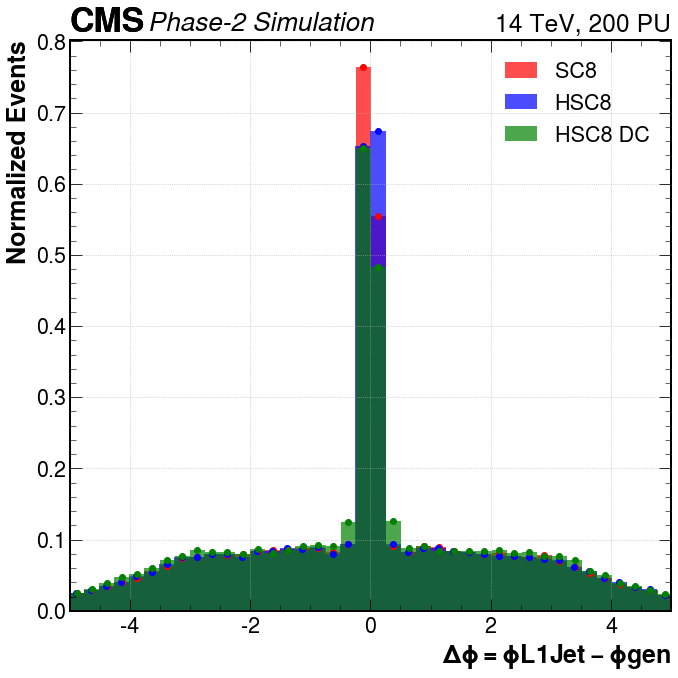

In [72]:
# ------------------------------------------------phi resolution  (normalised)-----------------------------------------

hist_values_sc, bin_edges_sc = np.histogram(delta_phi_all_np_sc, bins=nbins, density=True)
hist_values_hsc, bin_edges_hsc = np.histogram(delta_phi_all_np_hsc, bins=nbins, density=True)
hist_values_hsc_dc, bin_edges_hsc_dc = np.histogram(delta_phi_all_np_hsc_dc, bins=nbins, density=True)

# Step 2: Calculate the bin centers for plotting the markers
bin_centers_sc = (bin_edges_sc[:-1] + bin_edges_sc[1:]) / 2
bin_centers_hsc = (bin_edges_hsc[:-1] + bin_edges_hsc[1:]) / 2
bin_centers_hsc_dc = (bin_edges_hsc_dc[:-1] + bin_edges_hsc_dc[1:]) / 2

# Step 3: Plot the normalized histograms
plt.hist(delta_phi_all_np_sc, bins=nbins, color='red', alpha=0.7, label='SC8', density=True)
plt.hist(delta_phi_all_np_hsc, bins=nbins, color='blue', alpha=0.7, label='HSC8', density=True)
plt.hist(delta_phi_all_np_hsc_dc, bins=nbins, color='green', alpha=0.7, label='HSC8 DC', density=True)

# Step 4: Plot the markers for the histograms
plt.plot(bin_centers_sc, hist_values_sc, marker='o', linestyle='', color='red')
plt.plot(bin_centers_hsc, hist_values_hsc, marker='o', linestyle='', color='blue')
plt.plot(bin_centers_hsc_dc, hist_values_hsc_dc, marker='o', linestyle='', color='green')

# Step 5: Additional plot settings
plt.grid(True)
plt.legend()

plt.xlabel(r'$\Delta \phi = \phi{L1Jet} - \phi{gen} $', fontsize=25, fontweight='bold')
plt.ylabel('Normalized Events', fontsize=25, fontweight='bold')
plt.xlim(-5, 5)  # Set x-axis range for eta resolution
plt.legend()

# Add CMS-style label
mplhep.cms.text("Phase-2 Simulation")
mplhep.cms.label("", llabel="", rlabel="14 TeV, 200 PU")

# Show the plots
plt.tight_layout()
plt.show()